1. Setup & Load Data

this is your first step in your data science process, loading the data and any tools you will use.

In [3]:
# Basic imports
import pandas as pd            # for loading, cleaning, and manipulating tabular data
import numpy as np             # for numerical operations, arrays, and handling missing values
import matplotlib.pyplot as plt # for visualizing data (histograms, boxplots, scatterplots, etc.)


# For model work to be done latter ex: scaling, encoding, and train/test split later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Make pandas show more columns
pd.set_option("display.max_columns", 50)

# === Load your data ===
df = pd.read_csv("workshop_fake_data.csv")

# Peek at the data
df.head()


,customer_id,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,churned,has_support_calls,last_payment,discount_code
0,1001,Samira Ali,2023-01-15,"$58,000",120.0,Houston,Basic,No,yes,2024-05-01,DISC10
1,1002,Robert King,2022-11-03,"$45,000",85.0,HOUSTON,Standard,Yes,no,2024-04-10,NaN
2,1003,Amina Y.,2023-02-20,"$102,000",300.0,houston,Premium,No,YES,2024-05-03,DISC20
3,1004,Michael Green,2022-09-01,"$35,000",75.0,Austin,Basic,No,No,2024-05-09,NaN
4,1005,Sofia Perez,2023-03-10,"$210,000",512.0,AUSTIN,Premium,Yes,yes,2024-03-28,disc10


## 2. Understanding Your Data (Workshop 1 Review)

Questions to answer:

- What is the **target** (y)? What are the **features** (X)?
- Which columns are:
  - Numerical (continuous / discrete)
  - Categorical
- Do any columns look like IDs, names, or “weird” codes?

We'll use:
- `df.info()` → dtypes, missing values
- `df.describe()` → quick stats for numerical columns


In [5]:
# Data types and non-null counts
df.info()

# Summary statistics for numeric columns
df.describe()

# Example: set your target column
target_col = "churned"

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

X.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        20 non-null     int64  
 1   full_name          18 non-null     object 
 2   signup_date        20 non-null     object 
 3   income             19 non-null     object 
 4   monthly_usage_gb   19 non-null     float64
 5   city               20 non-null     object 
 6   subscription_type  20 non-null     object 
 7   churned            20 non-null     object 
 8   has_support_calls  20 non-null     object 
 9   last_payment       19 non-null     object 
 10  discount_code      8 non-null      object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.8+ KB


,customer_id,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,has_support_calls,last_payment,discount_code
0,1001,Samira Ali,2023-01-15,"$58,000",120.0,Houston,Basic,yes,2024-05-01,DISC10
1,1002,Robert King,2022-11-03,"$45,000",85.0,HOUSTON,Standard,no,2024-04-10,NaN
2,1003,Amina Y.,2023-02-20,"$102,000",300.0,houston,Premium,YES,2024-05-03,DISC20
3,1004,Michael Green,2022-09-01,"$35,000",75.0,Austin,Basic,No,2024-05-09,NaN
4,1005,Sofia Perez,2023-03-10,"$210,000",512.0,AUSTIN,Premium,yes,2024-03-28,disc10


from this analisis we can see we have 20 data entires and the number of NUll values in each column. for example for discount_code we have 8 non Null, so 12 Null. more on how to deal with this later  

## 3. Fixing Data Types

Examples:
- "18,000" → numeric
- "$50,000" → numeric
- "2024-01-01" as string → `datetime`
- "yes"/"no" → boolean (0/1)

Why?
- You can’t do math on text. Models require numeric features.
- Datetime allows you to extract year, month, day, etc.


In [6]:
# Example: fix "income" like "18,000" or "$18,000"

# 1. Remove non-numeric characters, then convert
if "income" in df.columns:
    df["income_clean"] = (
        df["income"] # find the income column
        .astype(str)                  # make sure it's string
        .str.replace(r"[$,]", "", regex=True)  # remove $ and ,
        .replace("nan", np.nan)       # fix literal "nan"
        .astype(float)                # numeric
    )

# Example: convert date string to datetime
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")  # invalid → NaT

# Example: convert a column with yes/no values to binary 1/0
for col in df.columns:
    if df[col].dtype == "object" and df[col].dropna().isin(["yes", "no", "Yes", "No"]).all():
        df[col + "_bin"] = (
            df[col]
            .str.lower()
            .map({"yes": 1, "no": 0})
        )

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        20 non-null     int64  
 1   full_name          18 non-null     object 
 2   signup_date        20 non-null     object 
 3   income             19 non-null     object 
 4   monthly_usage_gb   19 non-null     float64
 5   city               20 non-null     object 
 6   subscription_type  20 non-null     object 
 7   churned            20 non-null     object 
 8   has_support_calls  20 non-null     object 
 9   last_payment       19 non-null     object 
 10  discount_code      8 non-null      object 
 11  income_clean       19 non-null     float64
 12  churned_bin        20 non-null     int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 2.2+ KB


and now it made two more columns for us, if we wanted to drop the original ones we could simply

In [ ]:
df = df.drop(columns=["income", "churned"])


## 4. Handling Missing Data (NaN)

Steps:
1. Detect missing values.
2. Decide: **drop or fill?**
   - Drop row (if dataset is large and missingness is small).
   - Fill with:
     - mean (continuous variables that look roughly normal not skewed)
     - median (continuous variables with a long tail)
     - mode (set as the most common category for categorical data columns)
     - "Unknown" categor (Instead of guessing, sometimes you make a NEW category called "Unknown".)
3. Drop columns with > 50–60% missing if they’re not important.


In [9]:
# Check overall missingness
df.isna().sum().sort_values(ascending=False)

# Example rule: drop columns with > 60% missing
missing_ratio = df.isna().mean()
cols_to_drop_missing = missing_ratio[missing_ratio > 0.60].index.tolist()
print("Dropping for too much missing:", cols_to_drop_missing)

df = df.drop(columns=cols_to_drop_missing)

# Example: define numeric and categorical columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# Simple imputation strategy:
# - Numeric: fill with median
# - Categorical: fill with mode (most frequent)

for col in numeric_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

for col in categorical_cols:
    mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
    df[col] = df[col].fillna(mode_val)

df.isna().sum()


Dropping for too much missing: []
Numeric: ['customer_id', 'monthly_usage_gb', 'income_clean', 'churned_bin']
Categorical: ['full_name', 'signup_date', 'income', 'city', 'subscription_type', 'churned', 'has_support_calls', 'last_payment', 'discount_code']


,0
customer_id,0
full_name,0
signup_date,0
income,0
monthly_usage_gb,0
city,0
subscription_type,0
churned,0
has_support_calls,0
last_payment,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        20 non-null     int64  
 1   full_name          20 non-null     object 
 2   signup_date        20 non-null     object 
 3   income             20 non-null     object 
 4   monthly_usage_gb   20 non-null     float64
 5   city               20 non-null     object 
 6   subscription_type  20 non-null     object 
 7   churned            20 non-null     object 
 8   has_support_calls  20 non-null     object 
 9   last_payment       20 non-null     object 
 10  discount_code      20 non-null     object 
 11  income_clean       20 non-null     float64
 12  churned_bin        20 non-null     int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 2.2+ KB


Now none of our rowns have missing features

In [10]:
df.head()

,customer_id,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,churned,has_support_calls,last_payment,discount_code,income_clean,churned_bin
0,1001,Samira Ali,2023-01-15,"$58,000",120.0,Houston,Basic,No,yes,2024-05-01,DISC10,58000.0,0
1,1002,Robert King,2022-11-03,"$45,000",85.0,HOUSTON,Standard,Yes,no,2024-04-10,DISC20,45000.0,1
2,1003,Amina Y.,2023-02-20,"$102,000",300.0,houston,Premium,No,YES,2024-05-03,DISC20,102000.0,0
3,1004,Michael Green,2022-09-01,"$35,000",75.0,Austin,Basic,No,No,2024-05-09,DISC20,35000.0,0
4,1005,Sofia Perez,2023-03-10,"$210,000",512.0,AUSTIN,Premium,Yes,yes,2024-03-28,disc10,210000.0,1


## 5. Removing Useless Columns

Examples:
- IDs, names (no predictive power)
- Columns with one unique value
- Columns that leak the answer (data leakage)


In [11]:
# Example: manually drop IDs
cols_to_drop_manual = []

for col in df.columns:
    if "customer_id" in col:
        cols_to_drop_manual.append(col)

print("Candidate ID/name columns:", cols_to_drop_manual)

# One-unique-value columns (useless)
one_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print("One-value columns:", one_value_cols)

# Combine all to drop (students can edit this list)
cols_to_drop = cols_to_drop_manual + one_value_cols
cols_to_drop = list(set(cols_to_drop))  # unique

print("Dropping columns:", cols_to_drop)
df = df.drop(columns=cols_to_drop)

df.head()


Candidate ID/name columns: ['customer_id']
One-value columns: []
Dropping columns: ['customer_id']


,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,churned,has_support_calls,last_payment,discount_code,income_clean,churned_bin
0,Samira Ali,2023-01-15,"$58,000",120.0,Houston,Basic,No,yes,2024-05-01,DISC10,58000.0,0
1,Robert King,2022-11-03,"$45,000",85.0,HOUSTON,Standard,Yes,no,2024-04-10,DISC20,45000.0,1
2,Amina Y.,2023-02-20,"$102,000",300.0,houston,Premium,No,YES,2024-05-03,DISC20,102000.0,0
3,Michael Green,2022-09-01,"$35,000",75.0,Austin,Basic,No,No,2024-05-09,DISC20,35000.0,0
4,Sofia Perez,2023-03-10,"$210,000",512.0,AUSTIN,Premium,Yes,yes,2024-03-28,disc10,210000.0,1


## 6. Handling Duplicates

- Fully duplicated rows (2 or more rows are the exact same, no need for the model to see it twice)
- Duplicate IDs (likely an error in data input)
- Keep the first / last / aggregate

We’ll use:
- `df.duplicated()`
- `df.drop_duplicates()`


In [12]:
# Count duplicate rows
num_dupes = df.duplicated().sum()
print("Number of fully duplicated rows:", num_dupes)

# Drop duplicate rows, keeping the first
df = df.drop_duplicates()

# Example: check for duplicate IDs in a specific column
id_col = "customer_id"  # change to your ID column if you have one
if id_col in df.columns:
    dup_ids = df[id_col][df[id_col].duplicated()]
    print("Example duplicate IDs:\n", dup_ids.head())


Number of fully duplicated rows: 0


## 7. Fixing Inconsistent Categories

Examples:
- "Yes / yes / YES"
- "Houston / HOUSTON / houston "
- Trailing spaces

We’ll:
- Lowercase text
- Strip whitespace
- Possibly replace common misspellings


In [13]:
# Apply to selected categorical columns
for col in categorical_cols:
    # Make sure it's string
    df[col] = df[col].astype(str)

    # Lowercase and strip whitespace
    df[col] = df[col].str.lower().str.strip()

# Example of fixing known typos or categories
# mapping = {"houston ": "houston", "huston": "houston"}
# df["city"] = df["city"].replace(mapping)

for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts().head())



Unique values in full_name:
full_name
ahmed noor       3
samira ali       1
robert king      1
amina   y.       1
michael green    1
Name: count, dtype: int64

Unique values in signup_date:
signup_date
2023-01-15    1
2022-11-03    1
2023-02-20    1
2022-09-01    1
2023-03-10    1
Name: count, dtype: int64

Unique values in income:
income
$102,000    2
$58,000     1
$45,000     1
$35,000     1
$210,000    1
Name: count, dtype: int64

Unique values in city:
city
houston        8
dallas         5
austin         4
san antonio    3
Name: count, dtype: int64

Unique values in subscription_type:
subscription_type
basic       8
premium     7
standard    5
Name: count, dtype: int64

Unique values in churned:
churned
no     13
yes     7
Name: count, dtype: int64

Unique values in has_support_calls:
has_support_calls
yes    11
no      9
Name: count, dtype: int64

Unique values in last_payment:
last_payment
2024-05-01    3
2024-05-03    2
2024-05-09    2
2024-05-02    2
2024-04-10    1
Name: cou

## 8. Outlier Treatment & Transformations

From Workshop 1:
- Outliers can distort **mean**, **variance**, and model fits.
- We can:
  - Remove them (if they are clear errors)
  - Cap them (winsorize)
  - Transform (log, sqrt, etc.)

We'll:
- Use IQR to detect outliers.
- Show a log transform example for a right-skewed variable.


income_clean bounds -> lower: -66000.00, upper: 224000.00
Number of outliers: 3


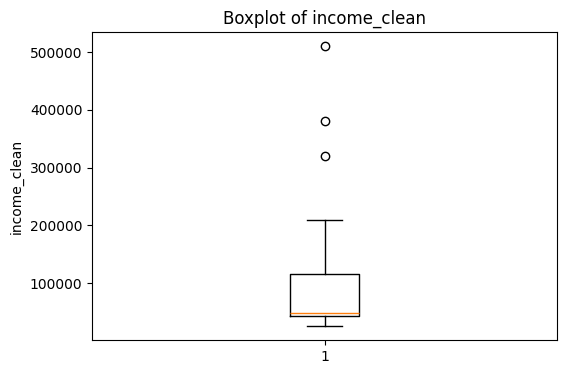

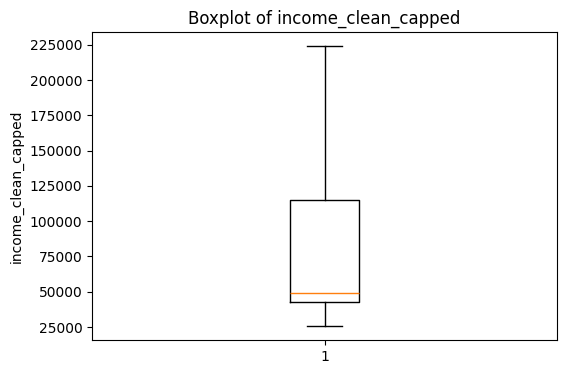

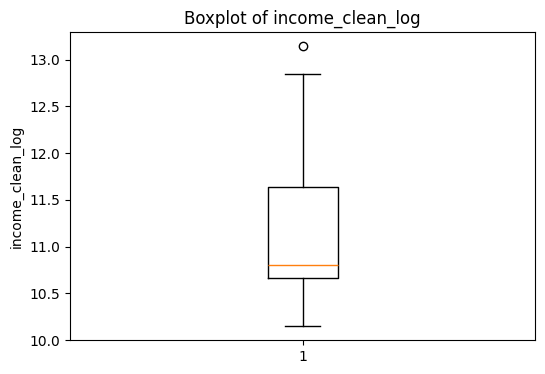

In [17]:
# Choose a numeric column to inspect
col = "income_clean"  # change as needed
if col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f"{col} bounds -> lower: {lower:.2f}, upper: {upper:.2f}")
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print("Number of outliers:", len(outliers))

    plt.figure(figsize=(6,4))
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()


    # Simple capping (clamping) example
    df[col + "_capped"] = df[col].clip(lower, upper)
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col+"_capped"])
    plt.title(f"Boxplot of {col+"_capped"}")
    plt.ylabel(col+"_capped")
    plt.show()
    #✔ Values below lower become lower
    # ✔ Values above upper become upper

    # Log transform example (for positive values)
    df[col + "_log"] = np.log1p(df[col].clip(lower=0))  # log(1+x) handles zeros
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col+"_log"])
    plt.title(f"Boxplot of {col+"_log"}")
    plt.ylabel(col+"_log")
    plt.show()
    # ✔ This reduces right-skew
    # ✔ Makes extreme values smaller


## 9. Feature Scaling / Normalization

Why?
- Some models use **distance** (KNN, SVM, K-means) or gradient descent.
- Features on very different scales can dominate others and lead to false results.

Two common scalers:
- **StandardScaler** → mean = 0, std = 1
- **MinMaxScaler** → range [0, 1]

Note: **Tree-based models** (Random Forest, XGBoost) don’t require scaling.


In [21]:
# All numeric columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Identify binary columns (only 0/1 or 0/1 with NaN)
binary_cols = [col for col in numeric_cols if df[col].dropna().nunique() == 2]

# Continuous columns = numeric but not binary
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

print("Numeric columns:", numeric_cols)
print("Binary columns (not scaling):", binary_cols)
print("Continuous columns (to scale):", continuous_cols)

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])

df_scaled.head()



Numeric columns: ['monthly_usage_gb', 'income_clean', 'churned_bin', 'income_clean_capped', 'income_clean_log']
Binary columns (not scaling): ['churned_bin']
Continuous columns (to scale): ['monthly_usage_gb', 'income_clean', 'income_clean_capped', 'income_clean_log']


,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,churned,has_support_calls,last_payment,discount_code,income_clean,churned_bin,income_clean_capped,income_clean_log
0,samira ali,2023-01-15,"$58,000",-0.460943,houston,basic,no,yes,2024-05-01,disc10,-0.439906,0,-0.434872,-0.263871
1,robert king,2022-11-03,"$45,000",-0.528586,houston,standard,yes,no,2024-04-10,disc20,-0.538337,1,-0.616068,-0.551626
2,amina y.,2023-02-20,"$102,000",-0.113061,houston,premium,no,yes,2024-05-03,disc20,-0.106759,0,0.178409,0.376237
3,michael green,2022-09-01,"$35,000",-0.547913,austin,basic,no,no,2024-05-09,disc20,-0.614052,0,-0.755450,-0.836582
4,sofia perez,2023-03-10,"$210,000",0.296665,austin,premium,yes,yes,2024-03-28,disc10,0.710968,1,1.683734,1.195055


In [25]:
df.head()

,full_name,signup_date,income,monthly_usage_gb,city,subscription_type,churned,has_support_calls,last_payment,discount_code,income_clean,churned_bin,income_clean_capped,income_clean_log
0,samira ali,2023-01-15,"$58,000",120.0,houston,basic,no,yes,2024-05-01,disc10,58000.0,0,58000.0,10.968216
1,robert king,2022-11-03,"$45,000",85.0,houston,standard,yes,no,2024-04-10,disc20,45000.0,1,45000.0,10.714440
2,amina y.,2023-02-20,"$102,000",300.0,houston,premium,no,yes,2024-05-03,disc20,102000.0,0,102000.0,11.532738
3,michael green,2022-09-01,"$35,000",75.0,austin,basic,no,no,2024-05-09,disc20,35000.0,0,35000.0,10.463132
4,sofia perez,2023-03-10,"$210,000",512.0,austin,premium,yes,yes,2024-03-28,disc10,210000.0,1,210000.0,12.254868


Notice how the values for income have changed completley. they are a lot smaller

## 10. Encoding for Model Use

- Models can’t read text → we must convert to numbers.
- **One-hot encoding**: for nominal categories (no natural order)
- **Ordinal encoding / label encoding**: only when there is a real order.

Example: city → one-hot; education level (primary < secondary < tertiary) → ordinal.


In [29]:
# Re-identify numeric and categorical columns after cleaning
categorical_cols= ['city', 'subscription_type']

# print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Example: separate features and target again after cleaning
X = df.drop(columns=[target_col])
y = df[target_col]

# ColumnTransformer for preprocessing
numeric_transformer = "passthrough"  # or you can add scaling here
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Fit and transform the features
X_encoded = preprocessor.fit_transform(X)
X_encoded

encoded_df = pd.DataFrame(
    X_encoded,
    columns=preprocessor.get_feature_names_out()
)

encoded_df.head()



Categorical cols: ['city', 'subscription_type']


,num__monthly_usage_gb,num__income_clean,num__churned_bin,num__income_clean_capped,num__income_clean_log,cat__city_austin,cat__city_dallas,cat__city_houston,cat__city_san antonio,cat__subscription_type_basic,cat__subscription_type_premium,cat__subscription_type_standard
0,120.0,58000.0,0.0,58000.0,10.968216,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,85.0,45000.0,1.0,45000.0,10.714440,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,300.0,102000.0,0.0,102000.0,11.532738,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,75.0,35000.0,0.0,35000.0,10.463132,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,512.0,210000.0,1.0,210000.0,12.254868,1.0,0.0,0.0,0.0,0.0,1.0,0.0


notice how now the columns are encoded ? for example we no longer have city but we do city houston, city austin, city san antonio....

## 11. Train/Test Split (to avoid leakage)

Even though modeling is in a later workshop, we must:

- Split the data into **train** and **test** *before*:
  - scaling
  - encoding
  - modeling

Why?
- If you scale on the entire dataset, information from the test set leaks into the training process(alows the model to cheat and see the answears of whats gonna be on its test).
- We want the test set to simulate **new, unseen data**.


In [30]:
# Rebuild numeric and categorical lists from X
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Train/test split BEFORE scaling & encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() <= 10 else None
)

# Preprocessor: scale numeric, one-hot encode categorical
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Example: just transform (no model yet)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape


((16, 77), (4, 77))

since our data set is very small we end up with 16 rows for training and 4 for testing